

# 1. Introduction



## A description of the problem and a discussion of the background

Dublin City Council and Tourism Ireland would like to Build a hotel on the North Side of Dublin to boost tourism and prosperity in the area ewhich has historically been less prosperious than the South side by encouraging tourism there. They'd like to set up a new luxury hotel in Malahide, an up-and-coming coastal town in the North however a look into what amenities nearby exist (restaurants, bars etc.) are in the vicinity as well as ensuring the new hotel is not near any existing hotels


# 2. Data

## A description of the data and how it will be used to solve the problem

Leveraging Foursquare Data, we will look into the immediate area surrounding Malahide, using bar and scatter plot chats from matplot lib to calculate the average distance from existing hotels to the city centre and location of other amenities from the centre as well as top amenitiesd categories to plot the best area to set up a new hotel nearest to these amenities and further from any existing hotels using folium as map vizualization.

Our key audience would be focused primarily on foreign tourists - 11 Million travel to Ireland every year passing through Dublin though less to the North side - highlighting the area of Malahide it's amentities e.g. beaches, food and place to stay that is in a prime location surrounded by options

### Import Libraries

In [58]:

# Import libraries
import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

#!conda install -c conda-forge folium=0.5.0 --yes
!pip install folium
import pandas as pd
import folium # map rendering library

print("*********   Loaded library     ***********")

*********   Loaded library     ***********


### Foursquare Credentials and input address

In [59]:
CLIENT_ID = 'IVQZMQ25XPU1ECLL0XYJTNLBHCXADZVJI12PVRD0RXJLRHAI' # your Foursquare ID
CLIENT_SECRET = 'DLDV1XYWTGM34CO3HWZBM0AA4PU2Y45AB54T333SNDOSZFPY' # your Foursquare Secret
VERSION = '20191028'
LIMIT = 150

address = "Malahide, Dublin"

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude =location.latitude   #8.079252 # location.latitude 
longitude =location.longitude #77.5499338 # location.longitude # 

dub='Malahide location is lat long : {},{}'.format(latitude,longitude)
print(dub)

Malahide location is lat long : 53.4508401,-6.15367


### Hotels in the Vicinity of Malahide

In [60]:
#Quering for hotels

search_query = 'hotel'

radius = 1000
url_hotel = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

#url

In [61]:
results_hotel = requests.get(url_hotel).json()

#results_hotel

### Find out how many hotels are in the area

In [62]:
venues_hotel = results_hotel['response']['venues']

# tranform venues into a dataframe and merging both data
dataframe_hotel = json_normalize(venues_hotel)


dataframe = pd.concat([dataframe_hotel])

print("There are {} hotels in Mahalhide".format(dataframe.shape[0]))

There are 2 hotels in Mahalhide


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


### info on existing hotels and distance

In [63]:
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    
# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

  
# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#dataframe_filtered
hotels_df=dataframe_filtered[['name','categories','distance','lat','lng']]
hotels_df.head()

,name,categories,distance,lat,lng
0,The Grand Hotel,Hotel,410,53.450448,-6.147508
1,Island View Hotel,Hotel,821,53.449778,-6.141400


### Location of Hotels mapped

In [64]:
hotels_map = folium.Map(location=[latitude, longitude], zoom_start=14) # generate map of centre
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='city centre',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(hotels_map)

# add the exitsting hotels as blue circle markers
for lat, lng, label in zip(hotels_df.lat, hotels_df.lng, hotels_df.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(hotels_map)

# display map
hotels_map

## 3.Methodology
### Here we will do some Exploratory Data Analysis as well as some clustering of venues to enble us to find best location for the hotel

### Distance from hotels and city centre

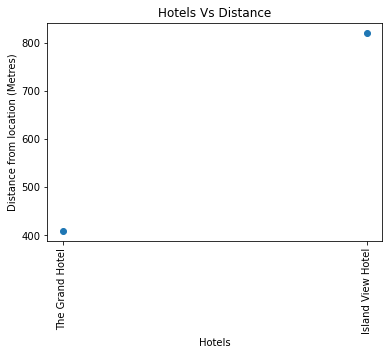

Average distance between hotels and city centre is 615 metres


In [65]:
distance_hotel_df=dataframe_filtered[['name','categories','distance','lat','lng']].sort_values('distance')

def plot_scatter_x():
    # this is for plotting purpose
    index = np.arange(len(distance_hotel_df.name))
    plt.scatter(distance_hotel_df.name, distance_hotel_df.distance)
    plt.xlabel('Hotels')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_hotel_df.name,rotation=90)
    plt.title('Hotels Vs Distance')
    plt.show()
plot_scatter_x()

print("Average distance between hotels and city centre is {} metres".format(int(sum(hotels_df['distance'])/hotels_df.shape[0])))

### the average distance between the hotels and Malahide centre is 615 metres
### The Grand Hotel being the nearest and the Island View being the furthest away

### all venue categories in the area. Tourists will want to visit amenities in the area so we look for other venue categories within half a km

In [66]:
radius=500
url_venues = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
#url_venues

In [67]:
# all venues in the area
import requests

results_venues = requests.get(url_venues).json()
'There are {} venues around Malahide.'.format(len(results_venues['response']['groups'][0]['items']))

'There are 32 venues around Malahide.'

### a Total of 32 amenities/venues around the city centre

In [68]:

items_venues = results_venues['response']['groups'][0]['items']
#items_venues[0]

In [69]:

dataframe_venues = json_normalize(items_venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe_venues.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered_venues = dataframe_venues.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered_venues['venue.categories'] = dataframe_filtered_venues.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered_venues.columns = [col.split('.')[-1] for col in dataframe_filtered_venues.columns]

dataframe_filtered_venues.name

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  if __name__ == '__main__':


0                                  Nautilus
1                     d|f (Donnybrook Fair)
2                                   deja vu
3                                    Kajjal
4                              Coffee Scene
5                             Scotch Bonnet
6                  Malahide Railway Station
7                                  Gibney's
8                                Il Sorriso
9                              Greedy Goose
10                                 Provence
11                                Siam Thai
12                              Bon Appetit
13                             That's Amore
14                     McGoverns Restaurant
15                               Giovanni's
16                                 Fowler's
17                          The Grand Hotel
18                             Beshoff Bros
19                                 Insomnia
20                                FishShack
21                                  Duffy's
22                              

### Let's sample some of these venues, their distance and latitude and logitude

In [70]:
#other categories
search_query_list = ['beach','castle','museum','restaurant'] 
radius =500
temp_df=[]
search_df=[]

def search_query_fn():   
    #Loop to run through urls and from json to pandas
    for i in range(len(search_query_list)):
        url= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_list[i], radius, LIMIT)
        
        results=requests.get(url).json()
        venues = results['response']['venues']
        
        #Normalize from json
        dataframe = json_normalize(venues)
        
        #Removing unwanted column headers
        dataframe.columns = [col.split('.')[-1] for col in dataframe.columns]
        temp_df.append(dataframe)
    
    #Loop to append dataframes to single dataframe
    for j in range(len(search_query_list)):
        data=temp_df[j]
        search_df.append(data)

# Function to run loop over queries
search_query_fn()

search_df = pd.concat(search_df,sort=True)
search_df['categories'] = search_df.apply(get_category_type, axis=1)
search_df = pd.DataFrame(search_df[['name','categories','distance','lat','lng']])
search_df

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,distance,lat,lng
0,Beachcomber Food Bar,Fish & Chips Shop,86,53.450545,-6.154885
0,McGoverns Restaurant,Steakhouse,10,53.450752,-6.153597
1,The Orchid Chinese Restaurant,Chinese Restaurant,51,53.451298,-6.153699
2,Cape Greko Greek & Cypriot Restaurant,Greek Restaurant,134,53.452034,-6.153965
3,Coast Restaurant,Breakfast Spot,398,53.450928,-6.147654
4,Silks,None,125,53.450790,-6.151784
5,Jaipur,Indian Restaurant,138,53.451404,-6.151813
6,Nautilus,Seafood Restaurant,180,53.452126,-6.152007


### Let us now collect venues from the Foursquare API

In [71]:
# Data extracted from foursquare venues
four_sq_venue=pd.DataFrame(dataframe_filtered_venues[['name','categories','distance','lat','lng','id']])

# Data extracted from search queries
new_venues=pd.DataFrame(search_df)

# Concatenate both dataframe
df_venue=pd.concat([four_sq_venue, new_venues],sort=True)

### Now we remove any venues that are categorized as Hotels

In [72]:
# venues (excluding hotels)
to_drop = ['hotel', 'hotels','Hotel']
df_venues = df_venue[~df_venue['name'].str.contains('|'.join(to_drop))].reset_index()
print("There are {} venues in Malahide,Dublin".format(df_venues.shape[0]))
df_venues[['name','distance','categories']]

There are 39 venues in Malahide,Dublin


,name,distance,categories
0,Nautilus,180,Seafood Restaurant
1,d|f (Donnybrook Fair),126,Gourmet Shop
2,deja vu,150,Café
3,Kajjal,165,Indian Restaurant
4,Coffee Scene,64,Café
5,Scotch Bonnet,99,American Restaurant
6,Malahide Railway Station,185,Train Station
7,Gibney's,61,Pub
8,Il Sorriso,94,Italian Restaurant
9,Greedy Goose,161,Diner


### Now we can vizualize all these venues by plotting their lat and long.  in comparison to the city centre in different colours

In [73]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=17) # generate map centred around Malahide

# add a red circle marker to represent Malahide centre
folium.features.CircleMarker(
    [latitude, longitude],
    radius=14,
    color='red',
    popup='Malahide',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the venues as green circle markers
for lat, lng, label in zip(df_venues.lat, df_venues.lng, df_venues.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(venues_map)
    

# display map
venues_map

### Now we can plot the distance of thse venues fom nearest to furthest from the centre as  a bar chart

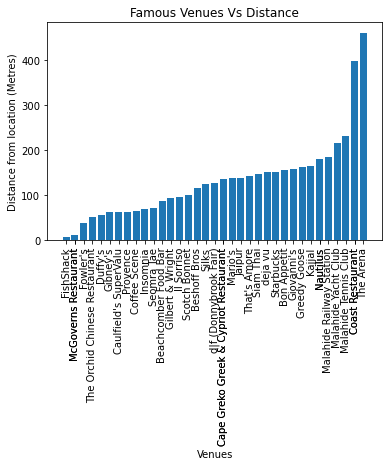

In [74]:
distance_venues_df=df_venues.sort_values('distance')

def plot_bar_venue():
    # this is for plotting purpose
    index = np.arange(len(distance_venues_df.name))
    plt.bar(distance_venues_df.name, distance_venues_df.distance)
    plt.xlabel('Venues')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_venues_df.name,rotation=90)
    plt.title('Famous Venues Vs Distance')
    plt.show()
plot_bar_venue()

### we can see that near the centre are a few restaurants (Fish Shack, Mc Governs), a SUpermarket (Supervalue) and Pubs such as Duffys near the centre and the furthest away is the Arena Health Club. We can also see that theire is a train station (Malahide Railway station) less than 20 meters away which will be handy for tourists coming to the town by public transport
#### Let's take a look now at the top venue categories for Malahide so it's clearer the most common sort of amenities nearby

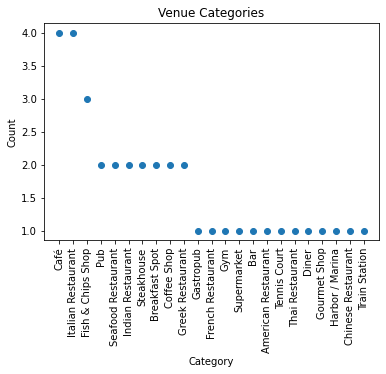

In [75]:
freq_venue=df_venues['categories'].value_counts()
freq_venue=pd.DataFrame(freq_venue).reset_index()
freq_venue.columns=['Category','Count']
freq_venue

def plot_scatter_categ():
    # this is for plotting purpose
    index = np.arange(len(freq_venue.Category))
    plt.scatter(freq_venue.Category, freq_venue.Count)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(freq_venue.Category,rotation=90)
    plt.title('Venue Categories')
    plt.show()
plot_scatter_categ()

### From this scatter chart we can see that Cafes and Italian restaurants are the most common venues followed by pubs which is perfect for tourist with plenty of places to eat as well as the chance to expeirence some Irish pubs. We can aslo see there is a HArbor which they may enjoy too

In [76]:
rating_df=[]

for k in range(df_venues.shape[0]):
    venue_id=df_venues.id[k]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    #print(result)
    try:
        #print(df_venues.name[k],result['response']['venue']['rating'])
        rating=result['response']['venue']['rating']
        rating_df.append(rating)
        
    except:
        #print(df_venues.name[k],'This venue has not been rated yet.')
        rating='No Rating Yet'
        rating_df.append(rating)

In [77]:
rate_dict = {'Venue': df_venues.name, 'Rating': rating_df,'distance':df_venues.distance}
rate_df=pd.DataFrame(rate_dict)
rate_df

,Venue,Rating,distance
0,Nautilus,No Rating Yet,180
1,d|f (Donnybrook Fair),No Rating Yet,126
2,deja vu,No Rating Yet,150
3,Kajjal,No Rating Yet,165
4,Coffee Scene,No Rating Yet,64
5,Scotch Bonnet,No Rating Yet,99
6,Malahide Railway Station,No Rating Yet,185
7,Gibney's,No Rating Yet,61
8,Il Sorriso,No Rating Yet,94
9,Greedy Goose,No Rating Yet,161


In [78]:
tips_df=[]

for k in range(df_venues.shape[0]):
    venue_id=df_venues.id[k]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    
    #print(result['response']['venue']['tips']['count'],result['response']['venue'])
    tips=result['response'],['tips'],['count']
    tips_df.append(tips)

In [79]:
tips_dict = {'Venue': df_venues.name, 'Tips': tips_df,'distance':df_venues.distance}
tips=pd.DataFrame(tips_dict)
tips=tips.sort_values('Tips',ascending = False)
tips

,Venue,Tips,distance
0,Nautilus,"({}, [tips], [count])",180
29,Malahide Tennis Club,"({}, [tips], [count])",231
22,Gilbert & Wright,"({}, [tips], [count])",92
23,Seomra Tae,"({}, [tips], [count])",71
24,Mario's,"({}, [tips], [count])",137
25,Caulfield's SuperValu,"({}, [tips], [count])",62
26,Starbucks,"({}, [tips], [count])",150
27,Cape Greko Greek & Cypriot Restaurant,"({}, [tips], [count])",134
28,Malahide Yacht Club,"({}, [tips], [count])",216
30,Coast Restaurant,"({}, [tips], [count])",398


In [80]:
# Add Tips column to Rating Dataframe
rate_df['Tips']=tips['Tips']

#Lets take values of only rated venues
only_rated_tips = rate_df[(rate_df['Rating']!='No Rating Yet') | (rate_df['Tips']!=0)]

only_rated_tips.reset_index(inplace = True,drop = True) 
only_rated_tips

,Venue,Rating,distance,Tips
0,Nautilus,No Rating Yet,180,"({}, [tips], [count])"
1,d|f (Donnybrook Fair),No Rating Yet,126,"({}, [tips], [count])"
2,deja vu,No Rating Yet,150,"({}, [tips], [count])"
3,Kajjal,No Rating Yet,165,"({}, [tips], [count])"
4,Coffee Scene,No Rating Yet,64,"({}, [tips], [count])"
5,Scotch Bonnet,No Rating Yet,99,"({}, [tips], [count])"
6,Malahide Railway Station,No Rating Yet,185,"({}, [tips], [count])"
7,Gibney's,No Rating Yet,61,"({}, [tips], [count])"
8,Il Sorriso,No Rating Yet,94,"({}, [tips], [count])"
9,Greedy Goose,No Rating Yet,161,"({}, [tips], [count])"


In [90]:
rated_list=[]
for i in range(len(only_rated_tips)):
    rated_tip_temp=only_rated_tips['Venue'][i]
    rated_list.append(rated_tip_temp)

#Masking all values present in list
mask = df_venues['name'].isin(rated_list)

final_venues = df_venues[mask]
#final_venues['location']=final_venues['lat'].astype(str).str.cat(final_venues['lng'].astype(str), sep=' - ')
final_venues.reset_index(inplace = True,drop = True) 

final_venues

,index,categories,distance,id,lat,lng,name
0,0,Seafood Restaurant,180,4bb3a74535f0c9b6edb1bc83,53.452126,-6.152007,Nautilus
1,1,Gourmet Shop,126,56619b23498e680e951e2fdf,53.451971,-6.153807,d|f (Donnybrook Fair)
2,2,Café,150,53aeb877498e7d85f524f3ea,53.451920,-6.155026,deja vu
3,3,Indian Restaurant,165,4b9cd6e5f964a520237e36e3,53.452125,-6.154929,Kajjal
4,4,Café,64,4b07d01af964a5202e0023e3,53.450618,-6.154561,Coffee Scene
5,5,American Restaurant,99,4ba6339df964a520293b39e3,53.449953,-6.153570,Scotch Bonnet
6,6,Train Station,185,4af43570f964a52096f021e3,53.450669,-6.156458,Malahide Railway Station
7,7,Pub,61,4c474ca334999c74d72d03fd,53.451386,-6.153527,Gibney's
8,8,Italian Restaurant,94,4b2cf7d3f964a5207acb24e3,53.451690,-6.153753,Il Sorriso
9,9,Diner,161,4b1eb9b4f964a5208c1e24e3,53.452062,-6.152343,Greedy Goose


### Although we tried to pull any rating info, most venues do not yet have rating thouhg with more tourism and traffic t the area we would hope this would change

### Now we can try to do some predictions to decide on best location for hotel based off these venues 

In [83]:
# one hot encoding
neighbor_onehot = pd.get_dummies(final_venues[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighbor_onehot['name'] = final_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [neighbor_onehot.columns[-1]] + list(neighbor_onehot.columns[:-1])
neighbor_onehot = neighbor_onehot[fixed_columns]

neighbor_onehot.head()

,name,American Restaurant,Bar,Breakfast Spot,Café,Chinese Restaurant,Coffee Shop,Diner,Fish & Chips Shop,French Restaurant,Gastropub,Gourmet Shop,Greek Restaurant,Gym,Harbor / Marina,Indian Restaurant,Italian Restaurant,Pub,Seafood Restaurant,Steakhouse,Supermarket,Tennis Court,Thai Restaurant,Train Station
0,Nautilus,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,d|f (Donnybrook Fair),0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,deja vu,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Kajjal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,Coffee Scene,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [84]:
neighbor_onehot.shape
neighbor_grouped = neighbor_onehot.groupby('name').mean().reset_index()

In [85]:
# Top 10 venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['name'] = neighbor_grouped['name']

In [86]:

# set number of clusters
kclusters = 3

neighbor_grouped_clustering = neighbor_grouped.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighbor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Clusters', kmeans.labels_)

neighbor_merged = final_venues

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
neighbor_merged = neighbor_merged.join(neighborhoods_venues_sorted.set_index('name'), on='name')

kmeans

KMeans(n_clusters=3, random_state=0)

## Now let's find best location for this new hotel

In [87]:

fin=neighbor_merged.groupby(['Clusters']).mean()

lati=sum(fin.lat)/len(fin.lat)
longi=sum(fin.lng)/len(fin.lng)

#Taking midpoint of top ten closest hotel
venues_lan=sum(final_venues.lat)/len(final_venues.lat)
venues_lng=sum(final_venues.lng)/len(final_venues.lng)

final_latitude=(lati+venues_lan)/2
final_longitude=(longi+venues_lng)/2

print("location of  new hotel is (blue spot):{},{}".format(final_latitude,final_longitude))

location of  new hotel is (blue spot):53.45136250121704,-6.15316179543189


## Let us vizualize these clusters

In [88]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=17)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

folium.features.CircleMarker(
    [final_latitude, final_longitude],
    radius=10,
    color='blue',
    popup='HOTEL',
    fill = True,
    fill_color = 'blue',
    fill_opacity = 0.6
).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighbor_merged['lat'], neighbor_merged['lng'], neighbor_merged['name'], neighbor_merged['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

### Now let's plot the New hotel location in green, the venues nearby in black, the city centre in purple and the exitsing hotels in blue

In [89]:

new_hotel_vs_all = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around Malahide


# add a green circle marker to represent the new hotel location
folium.features.CircleMarker(
    [final_latitude, final_longitude],
    radius=10,
    color='green',
    popup='New Hotel',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(new_hotel_vs_all)


# add a purple circle marker to represent the city centre
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='purple',
    popup='city centre',
    fill = True,
    fill_color = 'purple',
    fill_opacity = 0.6
).add_to(new_hotel_vs_all)

# add the existing hotels as blue circle markers
for lat, lng, label in zip(hotels_df.lat, hotels_df.lng, hotels_df.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(new_hotel_vs_all)
    
    
    
    
markers_colors = []
for lat, lon, poi, cluster in zip(neighbor_merged['lat'], neighbor_merged['lng'], neighbor_merged['name'], neighbor_merged['categories']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7).add_to(new_hotel_vs_all)


# display map
new_hotel_vs_all

# 4. Results:
## The location of the new hotel should be:  53.45136250121704,-6.15316179543189 and will be the hotel nearest to the centre and most amentities compared to the other hotels so it is in a prime location to attract tourists. It will be off the main thoroughfare of Main street so it not be too noisy and has restaurants, pubs and a supermarket directly surrounding it.



# 5.Discussion

## K means output was near city centre and surrounded by nearby amenities. However the lack of rating data is a limitation as we could have formatted  by top rated location otherwise. This could be expected as Gorusquare would be less popular in Ireland than say Google Maps or Yelp for ratings

# 6. Conclusion

## Dublin Council and Irish Tourism know where they could build a new hotel in Malahide close to amenities to attract tourists to the area and promote North Dublin in ads by highlighting this new hotel and all the great restaurnats and pubs in walking distance and this tourism would drive more money to the town in the hopes of making it more prosperous